In [35]:
import os
import sys
import collections
import pickle
import json
import collections

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from scipy import stats
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
plt.rcParams['figure.figsize'] = [16, 9]

In [13]:
sensory_words_traindf = pd.DataFrame()
sensory_words_testdf = pd.DataFrame()
words_embedding_dict = {}

In [14]:
def get_assigned_words(seq_clusters, cluster_words, axis, flag_train=False):

    # _assign word to each cluster of the subsequence usnig numpy where function
    assigned_words = np.where(
        seq_clusters != 0, seq_clusters, cluster_words[0])
    for idx in range(1, len(cluster_words)):
        assigned_words = np.where(
            seq_clusters != idx, assigned_words, cluster_words[idx])

    if flag_train:
        sensory_words_traindf[axis] = assigned_words
        assigned_clusterWord = pd.DataFrame(
            data=assigned_words, columns=['cluster_word'])
        return assigned_clusterWord
    else:
        sensory_words_testdf[axis] = assigned_words


def clustering(statistic_train_df, statistic_test_df, axis, cluster_cnts, cluster_words):

    statistic_train_df = Normalizer().fit_transform(np.array(statistic_train_df))
    statistic_test_df = Normalizer().fit_transform(np.array(statistic_test_df))

    model = KMeans(n_clusters=cluster_cnts,
                   random_state=234).fit(statistic_train_df)

    cluster_ids = pd.DataFrame(model.predict(
        statistic_train_df), columns=['cluster ID'])
    cluster_test_ids = pd.DataFrame(model.predict(
        statistic_test_df), columns=['cluster ID'])

    seq_clusters = cluster_ids.to_numpy()
    assigned_clusterWord = get_assigned_words(
        seq_clusters, cluster_words, axis, flag_train=True)
    get_assigned_words(cluster_test_ids.to_numpy(), cluster_words, axis)

    centroids_of_clusters = pd.DataFrame(model.cluster_centers_[cluster_ids['cluster ID']],
                                         columns=[f'dim_{val}' for val in range(statistic_train_df.shape[1])])
    result = pd.concat([assigned_clusterWord, centroids_of_clusters], axis=1)
    result = result.drop_duplicates()

    return result


# generating names for cluster count
def generate_cluster_names(sequence_names, cluster_cnt=100):

    words_dict = {}

    for seq in sequence_names:
        prefix = seq
        words_dict[seq] = [prefix+'_'+str(i) for i in range(cluster_cnt)]

    return words_dict


def cluster_word_sort(axis_clusters, cluster_names):

    result = axis_clusters.loc[(
        axis_clusters['cluster_word'] == cluster_names)]

    return result.iloc[:, 1:]


def perform_clustering(statistics_train, statistics_test, channels, cluster_cnts, words_generation_flag=False):

    centroid_statistic = []

    words_dict = generate_cluster_names(channels, cluster_cnts)

    for statistic_train_df, statistic_test_df, axis in zip(statistics_train, statistics_test, channels):

        cluster_names = words_dict[axis]
        axis_clusters = clustering(
            statistic_train_df, statistic_test_df, axis, cluster_cnts, cluster_names)

        for j in range(len(cluster_names)):

            cluster_stats = cluster_word_sort(axis_clusters, cluster_names[j])
            centroid_statistic.append(cluster_stats)
            words_embedding_dict[cluster_names[j]] = cluster_stats.values[0].tolist()

    # stop words generation
    #stop_words_generation(channels)
    if words_generation_flag:
        # new words generations inter sensor channels for train
        new_words_generation(channels, flag_train=True)
        # new words generations inter sensor channels for test
        new_words_generation(channels)
        embeddings_filepath = os.getcwd(
        ) + f'/../data/sub_sequence_output/word_embeddings_from_clusters.json'
        with open(embeddings_filepath, 'w') as fp:
            json.dump(words_embedding_dict, fp)
    else:

        embeddings_filepath = os.getcwd(
        ) + f'/../data/sub_sequence_output/word_embeddings_from_clusters.txt'
        pd.concat(centroid_statistic).to_csv(
            embeddings_filepath, index=False, header=False)

    # writing train documents to text files
    write_clustering_output(sensory_words_traindf.columns[2:], flag_train=True)
    # writing test documents to text files
    write_clustering_output(sensory_words_testdf.columns[2:])

    print(f'Finished generate_subsequences_uci_har  : {cluster_cnts} ')

In [17]:
def stop_words_generation(channels):

    stop_word_list = []

    def each_channel(channel):

        stopwords = sensory_words_traindf[[channel, 'activityID']].groupby(channel)[
            'activityID'].nunique()
        stopwords = stopwords[stopwords > 3].keys().tolist()

        return stopwords

    for channel in channels:

        stop_word_list.extend(each_channel(channel))

    with open(os.getcwd() + f'/../../data/stopwords.pkl', 'wb') as f:
        pickle.dump(stop_word_list, f)


def write_clustering_output(channels, flag_train=False):

    if flag_train:

        # _combine individual words as documents
        sensory_words_traindf['final_sub_sequence'] = sensory_words_traindf[channels].apply(
            lambda row: ' '.join(row.values.astype(str)), axis=1)
        # _save the combined values to text files
        for subject in sensory_words_traindf['subject_id'].unique():
            activity = sensory_words_traindf.loc[(
                sensory_words_traindf['subject_id'] == subject)]['activityID'].values[0]
            output_filepath = os.getcwd() + f'/../data/documents/train/activity_subseq_' + \
                str(subject) + '_' + str(activity) + '.txt'
            sensory_words_traindf.loc[(sensory_words_traindf['subject_id'] == subject)][[
                'final_sub_sequence']].to_csv(output_filepath, sep='\t', index=False, header=False)

    else:

        # _combine individual words as documents
        sensory_words_testdf['final_sub_sequence'] = sensory_words_testdf[channels].apply(
            lambda row: ' '.join(row.values.astype(str)), axis=1)
        # _save the combined values to text files
        for subject in sensory_words_testdf['subject_id'].unique():
            activity = sensory_words_testdf.loc[(
                sensory_words_testdf['subject_id'] == subject)]['activityID'].values[0]
            output_filepath = os.getcwd() + f'/../data/documents/test/activity_subseq_' + \
                str(subject) + '_' + str(activity) + '.txt'
            sensory_words_testdf.loc[(sensory_words_testdf['subject_id'] == subject)][[
                'final_sub_sequence']].to_csv(output_filepath, sep='\t', index=False, header=False)


def form_words(row, flag_train=False):

    temp = list(row.values.astype(str))
    dict_key = ''.join(temp)

    if dict_key not in words_embedding_dict.keys():

        for _ in range(len(words_embedding_dict[temp[0]])):
            vec_list = []
            for val in temp:
                vec_list.append(words_embedding_dict[val])

        words_embedding_dict[dict_key] = feature_sum(vec_list)

    return dict_key


def generate_word_combinations(word_combinations, flag_train):

    for combinations in word_combinations:
        #acc_axis = combinations[0]
        #temp = combinations[1:]
        new_channel_key = ''.join(combinations)
        if flag_train:
            sensory_words_traindf[new_channel_key] = sensory_words_traindf[combinations].apply(
                lambda row: form_words(row, flag_train), axis=1)
        else:
            sensory_words_testdf[new_channel_key] = sensory_words_testdf[combinations].apply(
                lambda row: form_words(row), axis=1)


def new_words_generation(channels, flag_train=False):

    two_word_combinations, three_word_combinations, four_word_combinations, five_word_combinations, six_word_combinations = False, True, True, True, True
    word_combinations_2 = [['X1', 'Y1'], ['X1', 'Z1'], ['Y1', 'Z1']]
    word_combinations_3 = [['X1', 'Y1', 'Z1'], ['Y1', 'Z1', 'Z2']]
    word_combinations_4 = [['X1', 'Y1', 'Y2', 'Z2'], ['X1', 'Z1', 'X2', 'Y2'], ['Y1', 'Z1', 'X2', 'Z2'], [
        'X1', 'Y1', 'X2', 'Z2'], ['X1', 'Z1', 'Y2', 'Z2'], ['Y1', 'Z1', 'X2', 'Y2']]
    word_combinations_5 = [['X1', 'Y1', 'Z1', 'Y2', 'Z2'], ['X1', 'Y1', 'Z1', 'X2', 'Z2'], [
        'X1', 'Y1', 'Z1', 'X2', 'Z2'], ['X1', 'Y1', 'Z1', 'Y2', 'Z2']]
    word_combinations_6 = [['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]

    if two_word_combinations:
        generate_word_combinations(word_combinations_2, flag_train)

    if three_word_combinations:
        generate_word_combinations(word_combinations_3, flag_train)

    if four_word_combinations:
        generate_word_combinations(word_combinations_4, flag_train)

    if five_word_combinations:
        generate_word_combinations(word_combinations_5, flag_train)

    if six_word_combinations:
        generate_word_combinations(word_combinations_6, flag_train)


def get_replacement_word(channel_values, replaceword):

    if channel_values[1] == replaceword:
        return channel_values[0]
    return channel_values[1]


def replace_leastidf_values():

    Y2_least_idf = collections.Counter(
        sensory_words_traindf['Y2'].tolist()).most_common()[0][0]
    Z2_least_idf = collections.Counter(
        sensory_words_traindf['Z2'].tolist()).most_common()[0][0]

    sensory_words_traindf['Y2'] = sensory_words_traindf[['Y1', 'Y2']].apply(
        lambda row: get_replacement_word(row.values, Y2_least_idf), axis=1)

    # sensory_words_traindf['Z2'] = sensory_words_traindf[['Z1', 'Z2']].apply(
    #     lambda row: get_replacement_word(row.values, Z2_least_idf), axis=1)

    sensory_words_testdf['Y2'] = sensory_words_testdf[['Y1', 'Y2']].apply(
        lambda row: get_replacement_word(row.values, Y2_least_idf), axis=1)

    # sensory_words_testdf['Z2'] = sensory_words_testdf[['Z1', 'Z2']].apply(
    #     lambda row: get_replacement_word(row.values, Z2_least_idf), axis=1)


def load_train_test_data(input_file_path, col_names):

    main_df = pd.read_csv(input_file_path, names=col_names)
    main_df = main_df.astype({'subject_id': int, 'activityID': int})

    return main_df


def window_sampling(main_df, window_length, window_overlap):

    max_window_index = len(main_df.index)
    num_of_subsequences = len(col_names)
    sub_sequences = [[] for x in range(num_of_subsequences)]

    window_index = 0

    while window_index <= (max_window_index - window_length):

        activity_sequence = main_df[col_names[1]
                                    ][window_index:window_index+window_length].tolist()
        subject_sequence = main_df[col_names[0]
                                   ][window_index:window_index+window_length].tolist()

        if len(set(subject_sequence)) == 1:
            sub_sequences[1].append(activity_sequence[0])
            sub_sequences[0].append(subject_sequence[0])

            for idx in range(2, num_of_subsequences):
                sub_sequences[idx].append(
                    main_df[col_names[idx]][window_index:window_index+window_length].tolist())

        window_index += window_overlap

    # _converting into numpy arrays
    np_sequences = np.asarray(sub_sequences[2:])
    subject_activity_seq = np.asarray(sub_sequences[:2])

    return subject_activity_seq, np_sequences


def feature_sum(vec_list):
    vec_list = np.array(vec_list)
    vec_sum = vec_list[0]
    try:
        for idx in range(1, len(vec_list)):
            vec_sum += vec_list[idx]
        vec_sum = vec_sum/len(vec_list)
    except:
        print(vec_list)
        exit()
    return vec_sum.tolist()


def onehotenocding_pooling(subject_activity_seq, subsequences, pooling_size=3):

    max_window_index = subject_activity_seq.shape[1]
    num_of_subsequences = len(col_names)
    pooled_features = [[] for x in range(num_of_subsequences)]
    window_index = 0

    while window_index <= (max_window_index - pooling_size):

        activity_sequence = subject_activity_seq[1
                                                 ][window_index:window_index+pooling_size].tolist()
        subject_sequence = subject_activity_seq[0
                                                ][window_index:window_index+pooling_size].tolist()

        if len(set(subject_sequence)) == 1:
            pooled_features[1].append(activity_sequence[0])
            pooled_features[0].append(subject_sequence[0])

            for idx in range(2, num_of_subsequences):
                pooled_features[idx].append(
                    feature_sum(subsequences[idx-2][window_index:window_index+pooling_size]))

        window_index += pooling_size

    # _converting into numpy arrays
    np_sequences = np.asarray(pooled_features[2:])
    subject_activity_seq = np.asarray(pooled_features[:2])

    return subject_activity_seq, np_sequences


def get_kmeans_clusters(sub_sequence_train, sub_sequence_test, feature_dim):

    model = KMeans(n_clusters=feature_dim,
                   random_state=5).fit(sub_sequence_train)
    cluster_train_ids = pd.DataFrame(model.predict(
        sub_sequence_train), columns=['cluster ID'])
    cluster_test_ids = pd.DataFrame(model.predict(
        sub_sequence_test), columns=['cluster ID'])

    one_hot_features_train = pd.get_dummies(cluster_train_ids.astype('str'))
    one_hot_features_test = pd.get_dummies(cluster_test_ids.astype('str'))

    return one_hot_features_train.values.tolist(), one_hot_features_test.values.tolist()

In [18]:
feature_dim = 6
pooling_size = 2
cluster_cnts = 10
window_length = 16
window_overlap = 16

train_file_path = os.getcwd() + f'/../data/output_csv/processed_data_train.csv'
test_file_path = os.getcwd() + f'/../data/output_csv/processed_data_test.csv'
col_names = ['subject_id', 'activityID',
             'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']

train_df = load_train_test_data(train_file_path, col_names)
test_df = load_train_test_data(test_file_path, col_names)

print('Starting windowing features....')

train_subject_activity_seq, train_subsequences = window_sampling(
    train_df, window_length=window_length, window_overlap=window_overlap)
test_subject_activity_seq, test_subsequences = window_sampling(
    test_df, window_length=window_length, window_overlap=window_overlap)

assert train_subject_activity_seq.shape[1] == train_subsequences.shape[1]
assert test_subject_activity_seq.shape[1] == test_subsequences.shape[1]

pooled_features_train = []
pooled_features_test = []

print('Starting feature clustering and pooling ....')
for idx in range(6):
    train_data, test_data = get_kmeans_clusters(
        train_subsequences[idx], test_subsequences[idx], feature_dim)

    pooled_features_train.append(train_data)
    pooled_features_test.append(test_data)

pooled_features_train = np.array(pooled_features_train)
pooled_features_test = np.array(pooled_features_test)

train_subject_activity_seq_pooled, train_subsequences_pooled = onehotenocding_pooling(
    train_subject_activity_seq, pooled_features_train, pooling_size)
test_subject_activity_seq_pooled, test_subsequences_pooled = onehotenocding_pooling(
    test_subject_activity_seq, pooled_features_test, pooling_size)

assert train_subject_activity_seq_pooled.shape[1] == train_subsequences_pooled.shape[1]
assert test_subject_activity_seq_pooled.shape[1] == test_subsequences_pooled.shape[1]

sensory_words_traindf['subject_id'] = train_subject_activity_seq_pooled[0]
sensory_words_traindf['activityID'] = train_subject_activity_seq_pooled[1]

sensory_words_testdf['subject_id'] = test_subject_activity_seq_pooled[0]
sensory_words_testdf['activityID'] = test_subject_activity_seq_pooled[1]

print(
    f'Finished feature extraction  : {cluster_cnts}, {window_length}, {window_overlap} ')

print(
    f'Starting Clustering  : {cluster_cnts}, {window_length}, {window_overlap} ')

perform_clustering(train_subsequences_pooled, test_subsequences_pooled,
                   channels=col_names[2:], cluster_cnts=cluster_cnts, words_generation_flag=True)

print('Ending histogram features....')

Starting windowing features....
Starting feature clustering and pooling ....
Finished feature extraction  : 10, 16, 16 
Starting Clustering  : 10, 16, 16 
Finished generate_subsequences_uci_har  : 10 
Ending histogram features....


In [19]:
sensory_words_traindf.head()

,subject_id,activityID,X1,Y1,Z1,X2,Y2,Z2,X1Y1Z1,Y1Z1Z2,X1Y1Y2Z2,X1Z1X2Y2,Y1Z1X2Z2,X1Y1X2Z2,X1Z1Y2Z2,Y1Z1X2Y2,X1Y1Z1Y2Z2,X1Y1Z1X2Z2,X1Y1Z1X2Y2Z2,final_sub_sequence
0,1,5,X1_1,Y1_5,Z1_4,X2_1,Y2_1,Z2_2,X1_1Y1_5Z1_4,Y1_5Z1_4Z2_2,X1_1Y1_5Y2_1Z2_2,X1_1Z1_4X2_1Y2_1,Y1_5Z1_4X2_1Z2_2,X1_1Y1_5X2_1Z2_2,X1_1Z1_4Y2_1Z2_2,Y1_5Z1_4X2_1Y2_1,X1_1Y1_5Z1_4Y2_1Z2_2,X1_1Y1_5Z1_4X2_1Z2_2,X1_1Y1_5Z1_4X2_1Y2_1Z2_2,X1_1 Y1_5 Z1_4 X2_1 Y2_1 Z2_2 X1_1Y1_5Z1_4 Y1_...
1,1,5,X1_1,Y1_1,Z1_4,X2_1,Y2_1,Z2_2,X1_1Y1_1Z1_4,Y1_1Z1_4Z2_2,X1_1Y1_1Y2_1Z2_2,X1_1Z1_4X2_1Y2_1,Y1_1Z1_4X2_1Z2_2,X1_1Y1_1X2_1Z2_2,X1_1Z1_4Y2_1Z2_2,Y1_1Z1_4X2_1Y2_1,X1_1Y1_1Z1_4Y2_1Z2_2,X1_1Y1_1Z1_4X2_1Z2_2,X1_1Y1_1Z1_4X2_1Y2_1Z2_2,X1_1 Y1_1 Z1_4 X2_1 Y2_1 Z2_2 X1_1Y1_1Z1_4 Y1_...
2,1,5,X1_1,Y1_5,Z1_4,X2_1,Y2_1,Z2_2,X1_1Y1_5Z1_4,Y1_5Z1_4Z2_2,X1_1Y1_5Y2_1Z2_2,X1_1Z1_4X2_1Y2_1,Y1_5Z1_4X2_1Z2_2,X1_1Y1_5X2_1Z2_2,X1_1Z1_4Y2_1Z2_2,Y1_5Z1_4X2_1Y2_1,X1_1Y1_5Z1_4Y2_1Z2_2,X1_1Y1_5Z1_4X2_1Z2_2,X1_1Y1_5Z1_4X2_1Y2_1Z2_2,X1_1 Y1_5 Z1_4 X2_1 Y2_1 Z2_2 X1_1Y1_5Z1_4 Y1_...
3,1,5,X1_1,Y1_5,Z1_4,X2_1,Y2_1,Z2_2,X1_1Y1_5Z1_4,Y1_5Z1_4Z2_2,X1_1Y1_5Y2_1Z2_2,X1_1Z1_4X2_1Y2_1,Y1_5Z1_4X2_1Z2_2,X1_1Y1_5X2_1Z2_2,X1_1Z1_4Y2_1Z2_2,Y1_5Z1_4X2_1Y2_1,X1_1Y1_5Z1_4Y2_1Z2_2,X1_1Y1_5Z1_4X2_1Z2_2,X1_1Y1_5Z1_4X2_1Y2_1Z2_2,X1_1 Y1_5 Z1_4 X2_1 Y2_1 Z2_2 X1_1Y1_5Z1_4 Y1_...
4,2,5,X1_1,Y1_5,Z1_4,X2_1,Y2_1,Z2_2,X1_1Y1_5Z1_4,Y1_5Z1_4Z2_2,X1_1Y1_5Y2_1Z2_2,X1_1Z1_4X2_1Y2_1,Y1_5Z1_4X2_1Z2_2,X1_1Y1_5X2_1Z2_2,X1_1Z1_4Y2_1Z2_2,Y1_5Z1_4X2_1Y2_1,X1_1Y1_5Z1_4Y2_1Z2_2,X1_1Y1_5Z1_4X2_1Z2_2,X1_1Y1_5Z1_4X2_1Y2_1Z2_2,X1_1 Y1_5 Z1_4 X2_1 Y2_1 Z2_2 X1_1Y1_5Z1_4 Y1_...


In [20]:
sensory_words_traindf[['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', 'activityID']].groupby('activityID')['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2'].nunique()

/Users/srisaipraveengadiyaram/opt/anaconda3/envs/glda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,X1,Y1,Z1,X2,Y2,Z2
activityID,,,,,,
1,9,8,9,10,10,10
2,9,8,9,10,10,10
3,9,8,9,10,10,10
4,3,8,8,8,9,9
5,2,7,7,9,8,9
6,1,9,9,10,9,7


In [21]:
sensory_words_traindf[['final_sub_sequence', 'activityID']].groupby('activityID')['final_sub_sequence'].nunique()

activityID
1    2279
2    2231
3    2126
4     158
5     133
6     170
Name: final_sub_sequence, dtype: int64

/Users/srisaipraveengadiyaram/opt/anaconda3/envs/glda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


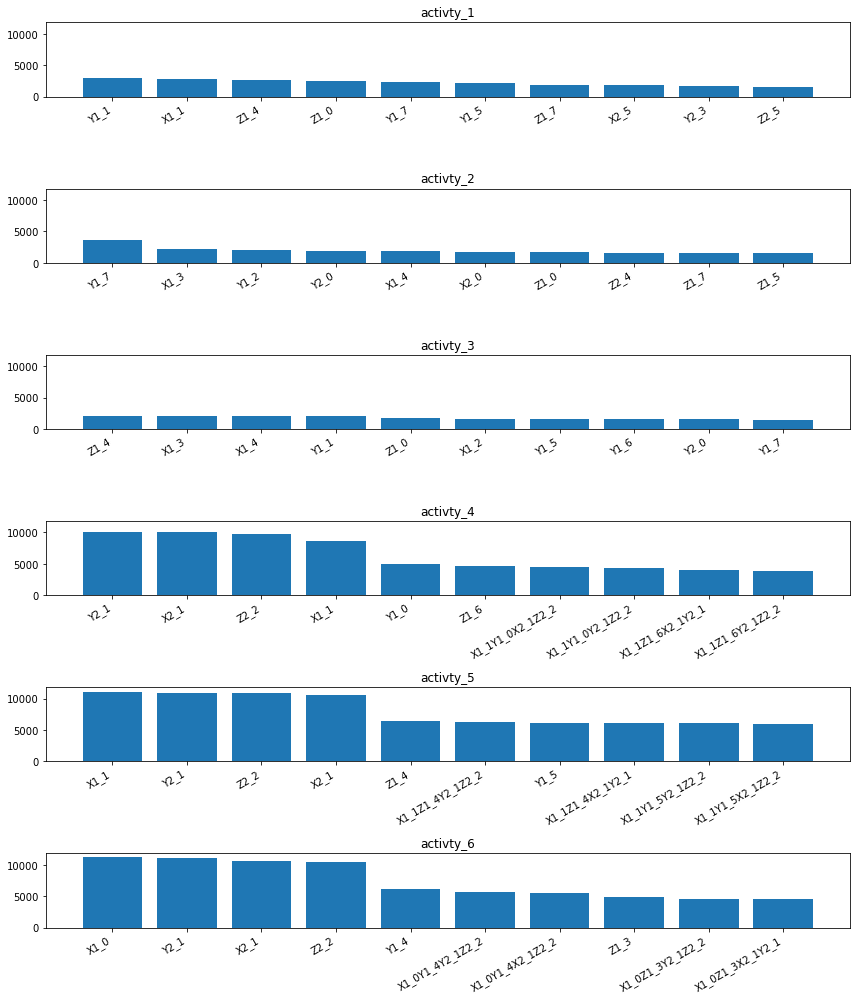

In [104]:
def process_data(cnt_list):
    x, y = [], []
    for item in cnt_list:
        x.append(item[0])
        y.append(item[1])
    return x, y

def plot_word_freqs(df):
    
    activity_docs = df[['final_sub_sequence', 'activityID']].groupby('activityID')['final_sub_sequence'].apply(' '.join).reset_index().values
    activity_wordcnts = {}
    for val in range(6):
        cnt = collections.Counter(activity_docs[val][1].split(' '))
        activity_wordcnts[val+1] = cnt.most_common()[:10]
        
    fig, axes = plt.subplots(6, figsize=(12, 14), sharey=True)
    for idx, ax in enumerate(axes):
        x, y = process_data(activity_wordcnts[idx+1])
        ax.bar(x, y)
        ax.set_title(f'activty_{idx+1}')
        ax.set_xticklabels(x,rotation=30, ha='right')
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    fig.tight_layout()
    plt.savefig('word_freq_train.png')
    plt.show()
    
plot_word_freqs(sensory_words_traindf)

/Users/srisaipraveengadiyaram/opt/anaconda3/envs/glda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


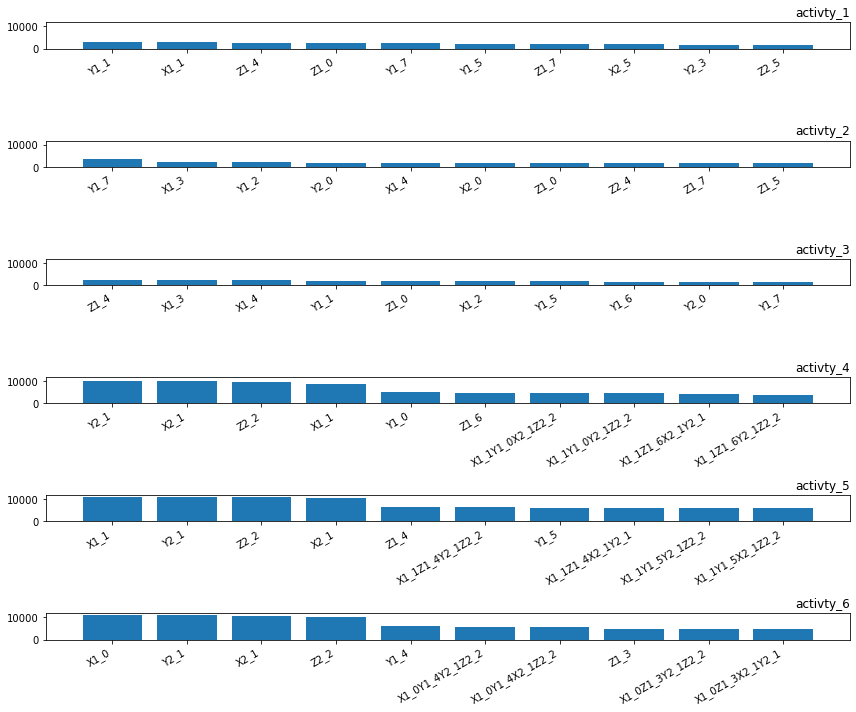

In [ ]:
sensory_words_traindf_1 = sensory_words_traindf.loc[(sensory_words_traindf['activityID'] == 1)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_traindf_2 = sensory_words_traindf.loc[(sensory_words_traindf['activityID'] == 2)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_traindf_3 = sensory_words_traindf.loc[(sensory_words_traindf['activityID'] == 3)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_traindf_4 = sensory_words_traindf.loc[(sensory_words_traindf['activityID'] == 4)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_traindf_5 = sensory_words_traindf.loc[(sensory_words_traindf['activityID'] == 5)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_traindf_6 = sensory_words_traindf.loc[(sensory_words_traindf['activityID'] == 6)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]

In [ ]:
sensory_words_traindf_1.value_counts()

In [ ]:
sensory_words_traindf_2.value_counts()

In [ ]:
sensory_words_traindf_3.value_counts()

In [ ]:
sensory_words_traindf_4.value_counts()

In [ ]:
sensory_words_traindf_5.value_counts()

In [ ]:
sensory_words_traindf_6.value_counts()

In [ ]:
sensory_words_traindf_1['X1'].value_counts()

In [ ]:
sensory_words_traindf_1['Y1'].value_counts()

In [ ]:
sensory_words_traindf_1['Z1'].value_counts()

In [ ]:
sensory_words_testdf_1 = sensory_words_testdf.loc[(sensory_words_testdf['activityID'] == 1)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_testdf_2 = sensory_words_testdf.loc[(sensory_words_testdf['activityID'] == 2)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_testdf_3 = sensory_words_testdf.loc[(sensory_words_testdf['activityID'] == 3)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_testdf_4 = sensory_words_testdf.loc[(sensory_words_testdf['activityID'] == 4)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_testdf_5 = sensory_words_testdf.loc[(sensory_words_testdf['activityID'] == 5)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]
sensory_words_testdf_6 = sensory_words_testdf.loc[(sensory_words_testdf['activityID'] == 6)][['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]

In [ ]:
sensory_words_testdf_4['X1'].value_counts()

In [ ]:
sensory_words_testdf_5['X1'].value_counts()

In [ ]:
sensory_words_testdf_6['X1'].value_counts()

In [ ]:
sensory_words_traindf['Z2'].value_counts()

In [ ]:
Y2_least_idf = collections.Counter(sensory_words_traindf['Y2'].tolist()).most_common()[0][0]
Z2_least_idf = collections.Counter(sensory_words_traindf['Z2'].tolist()).most_common()[0][0]

print(f'{Y2_least_idf} -- {Z2_least_idf}')

In [ ]:
def get_replacement_word(channel_values, replaceword):

    if channel_values[1] == replaceword:
        return channel_values[0]
    return channel_values[1]


def replace_leastidf_values():

    Y2_least_idf = collections.Counter(
        sensory_words_traindf['Y2'].tolist()).most_common()[0][0]
    Z2_least_idf = collections.Counter(
        sensory_words_traindf['Z2'].tolist()).most_common()[0][0]

    sensory_words_traindf['Y2'] = sensory_words_traindf[['Y1', 'Y2']].apply(
        lambda row: get_replacement_word(row.values, Y2_least_idf), axis=1)

    sensory_words_traindf['Z2'] = sensory_words_traindf[['Z1', 'Z2']].apply(
        lambda row: get_replacement_word(row.values, Z2_least_idf), axis=1)

In [ ]:
#replace_leastidf_values()